# Пример анализа на инструменте BTCUSDT


In [ ]:
import pandas as pd

from metrics import sma, ema, macd, rsi, volume_profile, value_area_bounds
from plot_data import plot_indicators
from plotly_plot import plot_indicators_plotly

pd.set_option("display.max_rows", 3)

DATA_PATH = "ohlc_BTCUSDT.csv"



In [2]:

raw = pd.read_csv(DATA_PATH)

if "open_time" in raw.columns:
    raw["open_time"] = pd.to_datetime(raw["open_time"], errors="coerce")
    df = raw.set_index("open_time")
elif "time" in raw.columns:
    raw["time"] = pd.to_datetime(raw["time"], errors="coerce")
    df = raw.set_index("time")


df = df.copy()
for col in ["open", "high", "low", "close", "volume"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")


end_date = df.index.max()
start_date = end_date - pd.DateOffset(months=3)
df = df.loc[df.index >= start_date]

symbol = df["symbol"].iloc[0] if "symbol" in df.columns else "SYMBOL"
df.tail()


,open,high,low,close,volume,symbol
open_time,,,,,,
2025-08-27,111763.22,112625.00,110345.42,111262.01,13392.60875,BTCUSDT
...,...,...,...,...,...,...
2025-08-31,108816.33,109480.02,108191.29,108518.00,6714.40408,BTCUSDT


In [3]:
closes = df["close"].tolist()

SMA_PERIODS = (12, 26)
EMA_PERIODS = (12, 26)

sma_series = {p: sma(closes, p) for p in SMA_PERIODS}
ema_series = {p: ema(closes, p) for p in EMA_PERIODS}
macd_line, signal_line, hist = macd(closes)
rsi_series = rsi(closes)

df_ind = df.copy()
for p in SMA_PERIODS:
    df_ind[f"SMA_{p}"] = sma_series[p]
for p in EMA_PERIODS:
    df_ind[f"EMA_{p}"] = ema_series[p]
df_ind["MACD"] = macd_line
df_ind["Signal"] = signal_line
df_ind["Hist"] = hist
df_ind["RSI"] = rsi_series

df_ind.tail()


,open,high,low,close,volume,symbol,SMA_12,SMA_26,EMA_12,EMA_26,MACD,Signal,Hist,RSI
open_time,,,,,,,,,,,,,,
2025-08-27,111763.22,112625.00,110345.42,111262.01,13392.60875,BTCUSDT,114138.478333,115702.330769,113817.308000,115010.389660,-1193.081661,-497.319282,-695.762378,41.591896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-31,108816.33,109480.02,108191.29,108518.00,6714.40408,BTCUSDT,112004.559167,115023.050000,111635.264926,113539.717772,-1904.452846,-1182.566561,-721.886285,38.250576


### Интерактивный график при помощи plotlpy

In [4]:
plot_indicators_plotly(df_ind.reset_index(), symbol, sma_periods=SMA_PERIODS, ema_periods=EMA_PERIODS, is_crypto=True)


### Растеризованный график при помощи matplotlib

c:\Users\grigo\Desktop\Новая папка (3)\plot_data.py:365: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



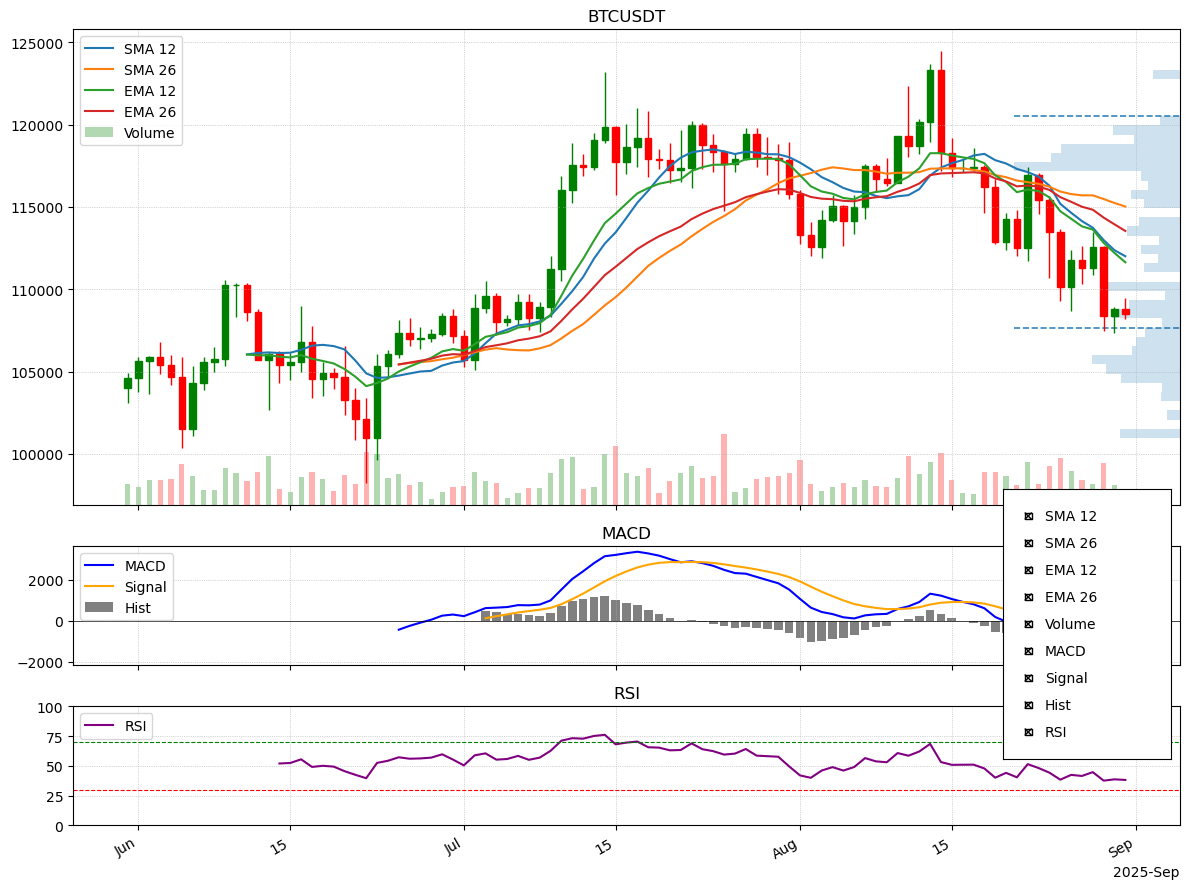

In [5]:
plot_indicators(df_ind, symbol, sma_periods=SMA_PERIODS, ema_periods=EMA_PERIODS, is_crypto=True)


### Расчет границ value area профиля объема

In [6]:

prices = df_ind["close"].tolist()
vols = df_ind["volume"].tolist()

hist, edges, max_bin = volume_profile(prices, vols, bins=40)
va = value_area_bounds(hist, edges, coverage=0.7)

print(f"Value Area bounds: {va}")


Value Area bounds: (107666.63799999999, 120513.60999999999)


BTC сейчас находится в фазе коррекции после роста, который завершился в конце августа. На это указывают скользящие средние: короткие линии расположены ниже длинных, а цена закрепилась под всеми скользящими.

Судя по профилю объёма, поддержка формируется на двух ключевых уровнях: первый — **107 500** (нижняя граница value area), второй — около **106 000** (предыдущий POC).

Линия MACD находится ниже сигнальной, что подтверждает сохранение нисходящего тренда. RSI удерживается в районе **40**, что указывает на слабость рынка, но до зоны перепроданности (**30 и ниже**) ещё не дошёл. Это значит, что нисходящее движение, вероятно, продолжится.

**Потенциальная точка входа**: целесообразно дождаться схождения MACD с сигнальной линией при одновременном снижении RSI к уровню **30 и ниже**, желательно вблизи ценовых уровней **107 500** или **106 000**.

### Сценарии входа

1. **На 107 500**

   * Если RSI опустится в диапазон **30–35**, а на MACD начнётся замедление снижения (гистограмма растёт вверх, но остаётся отрицательной), можно рассмотреть частичный вход.

2. **На 106 000**

   * Более сильная зона поддержки.
   * Оптимальный вариант: RSI < **30** (зона перепроданности) + MACD готовится к пересечению вверх.
   * Здесь можно искать основной вход, особенно если объёмы подтвердят защиту уровня.



### Сценарии выхода

1. **111 500**

   * Первая зона сопротивления - точка с наименьшим объемом торгов, есть смысл ожидать либо резкого разворота, либо резкого пролета до следующего уровня сопротивления. 
   * Стоит зафиксировать часть позиции, особенно если RSI поднимется выше **60**.

2. **115 000 - 118 000**

   * Ключевая область сопротивления по скользящим и профилю объёма - кластер с высоким проторгованным объемом.
   * Стоит закрыть основную часть позиции.

3. **120 000+**

   * При закреплении цены выше 118000 имеет смысл поставить трейлинг-стоп для освобождения остатка позиции по мере обновления локальных минимумов на мелких таймфреймах вплоть до уровня 120000
   * При фейле на тесте уровня 118000 стоит закрыть оставшуюся позицию полностью
